# Read the data

In [28]:
!pip install lightning wandb

In [29]:
!WANDB_API_KEY=8c780297be240a84f5c8b7d669cb158839b2637a

In [2]:
import pandas as pd
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import lightning as pl
from pytorch_lightning.loggers import WandbLogger
import random
import wandb

In [31]:
!WANDB_API_KEY=8c780297be240a84f5c8b7d669cb158839b2637a wandb login

wandb: Currently logged in as: cs20b075. Use `wandb login --relogin` to force relogin


In [3]:
path = "aksharantar_sampled/hin"
train_path = path + "/hin_train.csv"
valid_path = path + "/hin_valid.csv"
test_path = path + "/hin_test.csv"

In [4]:
def get_data(path):
    dataset = pd.read_csv(path, header=None)
    dataset = dataset.values
    input = dataset[:, 0]
    output = dataset[:, 1]
    return input, output

In [5]:
train_dataset = get_data(train_path)
val_dataset = get_data(valid_path)

In [6]:
def convert_word_to_tensor(word, lang):
    lang_to_int = {'SOS': 0, 'EOS': 1, 'PAD': 2}
    if lang == 'eng':
        lang_to_int.update({chr(i): i-94 for i in range(97, 123)})
    elif lang == 'hin':
        lang_to_int.update({chr(i): i-2300 for i in range(2304, 2432)})
    
    a = [lang_to_int['SOS']]

    for i in word:
        a.append(lang_to_int[i])

    a.append(lang_to_int['EOS'])
    if len(a) < 24:
        a.extend([lang_to_int['PAD']]*(24-len(a)))
    
    return torch.tensor(a)

In [7]:
class AksharantarDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.input = dataset[0]
        self.output = dataset[1]
        mask = np.array([len(elem) < 21 for elem in self.input]) & np.array([len(elem) < 21 for elem in self.output])
        self.input = self.input[mask]
        self.output = self.output[mask]
        self.len = len(self.input)
    
    def __getitem__(self, index):
        return convert_word_to_tensor(self.input[index], 'eng'), convert_word_to_tensor(self.output[index], 'hin')
    
    def __len__(self):
        return self.len

In [8]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, dataset, val_dataset, batch_size=32):
        super().__init__()
        self.dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        dataset = AksharantarDataset(self.dataset)
        return DataLoader(dataset, batch_size=self.batch_size, num_workers=2)
    def val_dataloader(self):
        dataset = AksharantarDataset(self.val_dataset)
        return DataLoader(dataset, batch_size=self.batch_size, num_workers=2)

In [9]:
train_loader = CustomDataModule(train_dataset, val_dataset, 32)
# val_loader = CustomDataModule(val_dataset, 32)

# Encoder model

In [10]:
class Encoder(pl.LightningModule):
    def __init__(self, input_size, hidden_size, cell_type, num_layers=1, dropout=0, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.cell_type = cell_type
        if cell_type == 'LSTM':
            self.rnn = nn.LSTM
        elif cell_type == 'GRU':
            self.rnn = nn.GRU
        else:
            self.rnn = nn.RNN
        self.direction = 2 if bidirectional else 1
        self.first_cell = self.rnn(hidden_size, hidden_size, bidirectional=bidirectional, batch_first=True)
        self.rnns = nn.ModuleList([self.rnn(hidden_size*self.direction, hidden_size, bidirectional=bidirectional, batch_first=True)]*(num_layers-1))
        self.num_layers = num_layers

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        # embedded = embedded.view(1, 1, -1)
        output = embedded
        output, hidden = self.first_cell(output, hidden)
        for i in range(self.num_layers-1):
            output, hidden = self.rnns[i](output, hidden)
        return output, hidden

    def init_hidden(self):
        if self.cell_type == 'LSTM':
            return torch.zeros(self.direction, self.hidden_size), torch.zeros(self.direction, self.hidden_size)
        return torch.zeros(self.direction, self.hidden_size, device=self.device)

# Decoder

In [11]:
class Decoder(pl.LightningModule):
    def __init__(self, output_size, hidden_size, cell_type, num_layers=1, bidirectional=False, dropout=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        if cell_type == 'LSTM':
            self.cell_type = nn.LSTM
        elif cell_type == 'GRU':
            self.cell_type = nn.GRU
        else:
            self.cell_type = nn.RNN
        self.first_cell = self.cell_type(hidden_size, hidden_size, bidirectional=bidirectional, batch_first=True)
        self.direction = 2 if bidirectional else 1
        self.rnns= nn.ModuleList([self.cell_type(hidden_size*self.direction, hidden_size, bidirectional=bidirectional, batch_first=True)]*(num_layers-1))
        self.out = nn.Linear(hidden_size*self.direction, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.num_layers = num_layers

    def forward(self, input, hidden):
        output = self.embedding(input)
        output = nn.functional.relu(output)
        output, hidden = self.first_cell(output, hidden)
        for i in range(self.num_layers-1):
            output, hidden = self.rnns[i](output, hidden)
        linear_output = self.out(output)
        output = self.softmax(self.out(output))
        if output.shape[0] == 1:
            output = output.squeeze(0)
        return output, hidden

# Seq2seq model

In [64]:
class Seq2seq(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)

    def forward(self, input):
        
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        
        batched = True if len(input.shape) > 1 else False
        if not batched:
            input = input.unsqueeze(0)
        input = input.to(self.device)
        batch_size = input.shape[0]
        input_length = input.shape[1]

        encoder_hidden = None
        encoder_hidden_outputs = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        encoder_output_gate = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        if self.encoder.cell_type == 'LSTM':
            a, b = [torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size)]*2
            encoder_hidden = a.to(self.device), b.to(self.device)
        else:
            encoder_hidden = torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size).to(self.device)
        for i in range(input_length):
            _, encoder_hidden_out = self.encoder(input[:, i].unsqueeze(1), encoder_hidden)
            encoder_hidden = encoder_hidden_out
            if self.encoder.cell_type == 'LSTM':
                encoder_hidden_outputs[i] = encoder_hidden_out[0]
                encoder_output_gate[i] = encoder_hidden_out[1]
            else:
                encoder_hidden_outputs[i] = encoder_hidden_out
        if self.encoder.cell_type == 'LSTM':
            decoder_hidden = encoder_hidden_outputs[-1], encoder_output_gate[-1]
        else:
            decoder_hidden = encoder_hidden_outputs[-1]
        decoder_input = torch.zeros(batch_size, 1, dtype=torch.long, device=self.device)
        output_sequences    = []
        for j in range(24):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_input = decoder_output.argmax(dim=-1)
            if not batched:
                decoder_input = decoder_input.unsqueeze(0)
            output_sequences.append(decoder_input)
        output_sequence = torch.tensor(output_sequences, device=self.device)
        if not batched:
            output_sequence = output_sequence.squeeze(0)
        return output_sequence
        
    def training_step(self, batch, batch_idx):
        input, target = batch
        
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        
        batched = True if len(input.shape) > 1 else False
        if not batched:
            input = input.unsqueeze(0)
            target = target.unsqueeze(0)
        input = input.to(self.device)
        target = target.to(self.device)
        batch_size = input.shape[0]
        input_length = input.shape[1]
        target_length = target.shape[1]

        encoder_hidden = None
        encoder_hidden_outputs = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        encoder_output_gate = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        if self.encoder.cell_type == 'LSTM':
            a, b = [torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size)]*2
            encoder_hidden = a.to(self.device), b.to(self.device)
        else:
            encoder_hidden = torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size).to(self.device)
        for i in range(input_length):
            # print(input[:, i].shape, encoder_hidden.shape)
            _, encoder_hidden_out = self.encoder(input[:, i].unsqueeze(1), encoder_hidden)
            encoder_hidden = encoder_hidden_out
            if self.encoder.cell_type == 'LSTM':
                encoder_hidden_outputs[i] = encoder_hidden_out[0]
                encoder_output_gate[i] = encoder_hidden_out[1]
            else:
                encoder_hidden_outputs[i] = encoder_hidden_out
        loss = 0
        correct_words = 0
        if self.encoder.cell_type == 'LSTM':
            decoder_hidden = encoder_hidden_outputs[-1], encoder_output_gate[-1]
        else:
            decoder_hidden = encoder_hidden_outputs[-1]
        if random.random() < 0.5: 
            decoder_input = target[:, 0].unsqueeze(1)
            correct = None
            for j in range(target_length):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                squeezed_output = decoder_output.squeeze(1)
                for i in range(batch_size):
                    loss += nn.functional.nll_loss(squeezed_output[i], target[i, j])
                decoder_input = target[:, j].unsqueeze(1)
                if correct is None:
                    correct = decoder_output.argmax(dim=-1) == target[:, j]
                else:
                    correct = (decoder_output.argmax(dim=-1) == target[:, j]) & correct
            correct_words = correct.sum()

        else:
            decoder_input = target[:, 0].unsqueeze(1)
            correct = None
            for j in range(target_length):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                squeezed_output = decoder_output.squeeze(1)
                for i in range(batch_size):
                    loss += nn.functional.nll_loss(squeezed_output[i], target[i, j])
                decoder_input = decoder_output.argmax(dim=-1)
                if correct is None:
                    correct = decoder_input == target[:, j]
                else:
                    correct = (decoder_input == target[:, j]) & correct
            correct_words = correct.sum()

        # print(correct_words, batch_size, correct_words/batch_size)
        reported_loss = loss / (batch_size * target_length)
        self.log('train_loss', reported_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', correct_words/batch_size, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        input, target = batch
        
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        
        batched = True if len(input.shape) > 1 else False
        if not batched:
            input = input.unsqueeze(0)
            target = target.unsqueeze(0)
        input = input.to(self.device)
        target = target.to(self.device)
        batch_size = input.shape[0]
        input_length = input.shape[1]
        target_length = target.shape[1]

        encoder_hidden = None
        encoder_hidden_outputs = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        encoder_output_gate = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        if self.encoder.cell_type == 'LSTM':
            a, b = [torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size)]*2
            encoder_hidden = a.to(self.device), b.to(self.device)
        else:
            encoder_hidden = torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size).to(self.device)
        for i in range(input_length):
            # print(input[:, i].shape, encoder_hidden.shape)
            _, encoder_hidden_out = self.encoder(input[:, i].unsqueeze(1), encoder_hidden)
            encoder_hidden = encoder_hidden_out
            if self.encoder.cell_type == 'LSTM':
                encoder_hidden_outputs[i] = encoder_hidden_out[0]
                encoder_output_gate[i] = encoder_hidden_out[1]
            else:
                encoder_hidden_outputs[i] = encoder_hidden_out
        loss = 0
        correct_words = 0
        if self.encoder.cell_type == 'LSTM':
            decoder_hidden = encoder_hidden_outputs[-1], encoder_output_gate[-1]
        else:
            decoder_hidden = encoder_hidden_outputs[-1]
        decoder_input = target[:, 0].unsqueeze(1)
        correct = None
        for j in range(target_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            squeezed_output = decoder_output.squeeze(1)
            for i in range(batch_size):
                loss += nn.functional.nll_loss(squeezed_output[i], target[i, j])
            decoder_input = decoder_output.argmax(dim=-1)
            if correct is None:
                correct = decoder_input == target[:, j]
            else:
                correct = (decoder_input == target[:, j]) & correct
        correct_words = correct.sum()

        # for i in range(batch_size):
        #     if self.encoder.cell_type == 'LSTM':
        #         decoder_hidden = encoder_hidden_outputs[i].view(self.decoder.direction, -1), encoder_output_gate[i].view(self.decoder.direction, -1)
        #     else:
        #         decoder_hidden = encoder_hidden_outputs[i].view(self.decoder.direction, -1)
        #     decoder_input = target[i, 0].unsqueeze(0)
        #     correct = True
        #     for j in range(target_length):
        #         decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        #         loss += nn.functional.nll_loss(decoder_output, target[i, j])
        #         decoder_input = torch.tensor([decoder_output.argmax().item()]).to(self.device)
        #         if correct and target[i, j]!= decoder_output.argmax().item():
        #             correct = False
        #     if correct:
        #         correct_words  += 1
        reported_loss = loss / (batch_size * target_length)
        self.log('val_loss', reported_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', correct_words/batch_size, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [65]:
encoder = Encoder(30, 64, cell_type="LSTM", num_layers=2, bidirectional=True, dropout=0.1)
decoder = Decoder(150, 64, cell_type="LSTM", num_layers=3, bidirectional=True)
model = Seq2seq(encoder, decoder)

In [66]:
convert_tensor_to_word(model(convert_word_to_tensor('hello', 'eng')), 'hin')

'००ऋ००ऋ००ऋ००ऋ००ऋ००ऋ००ऋ००ऋ'

In [66]:
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 167 K 
1 | decoder | Decoder | 194 K 
------------------------------------
362 K     Trainable params
0         Non-trainable params
362 K     Total params
1.451     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1599/1599 [06:32<00:00,  4.07it/s, v_num=186, train_loss_step=1.060, train_acc_step=0.000, val_loss_step=1.150, val_loss_epoch=1.200, val_acc=0.000, train_loss_epoch=1.310, train_acc_epoch=0.000]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1599/1599 [06:32<00:00,  4.07it/s, v_num=186, train_loss_step=1.060, train_acc_step=0.000, val_loss_step=1.150, val_loss_epoch=1.200, val_acc=0.000, train_loss_epoch=1.310, train_acc_epoch=0.000]


In [13]:
def convert_tensor_to_word(tensor, lang):
    int_to_lang = {0: 'SOS', 1: 'EOS', 2: 'PAD'}
    if lang == 'eng':
        int_to_lang.update({i-94: chr(i) for i in range(97, 123)})
    elif lang == 'hin':
        int_to_lang.update({i-2300: chr(i) for i in range(2304, 2432)})
    
    word = ''
    for i in tensor:
        word += int_to_lang[i.item()]
    return word

In [19]:
convert_tensor_to_word(model(convert_word_to_tensor('gharelu', 'eng')), 'hin')

UnboundLocalError: cannot access local variable 'target' where it is not associated with a value

In [26]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'hidden_size': {
            'values': [64, 128, 256],
        },
        'encoder_num_layers': {
            'values': [1, 2, 3],
        },
        'decoder_num_layers': {
            'values': [1, 2, 3],
        },
        'bidirectional': {
            'values': [True, False],
        },
        'cell_type': {
            'values': ['LSTM', 'GRU'],
        },
    }
}

In [31]:
def sweep_fn():
    wandb.init()
    config = wandb.config
    dropout_val = 0
    encoder=Encoder(30, config.hidden_size, config.cell_type, num_layers=config.encoder_num_layers, bidirectional=config.bidirectional)
    decoder = Decoder(150, config.hidden_size, config.cell_type, num_layers=config.decoder_num_layers, bidirectional=config.bidirectional)
    model = Seq2seq(encoder, decoder)
    logger = WandbLogger(project='CS6910 Assignment 3', entity='cs20b075')
    trainer = pl.Trainer(max_epochs=5, precision=16, logger=logger)
    trainer.fit(model, train_loader)

In [28]:
wandb.login(key="8c780297be240a84f5c8b7d669cb158839b2637a")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs20b075. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/sooraj/.netrc


True

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_config, project="CS6910 Assignment 3")
wandb.agent(sweep_id=sweep_id, function=sweep_fn, count=10)

In [ ]:
wandb.agent(sweep_id="1aw4o8ik", function=sweep_fn, count=10, project="CS6910 Assignment 3")

In [ ]:
wandb.finish()

# Adding attention to the Seq2Seq model

In [14]:
class AttnDecoder(pl.LightningModule):
    def __init__(self, output_size, hidden_size, attention_size, cell_type, num_layers=1, bidirectional=False, dropout=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        if cell_type == 'LSTM':
            self.cell_type = nn.LSTM
        elif cell_type == 'GRU':
            self.cell_type = nn.GRU
        else:
            self.cell_type = nn.RNN
        self.first_cell = self.cell_type(hidden_size, hidden_size, bidirectional=bidirectional, batch_first=True)
        self.direction = 2 if bidirectional else 1
        self.rnns= nn.ModuleList([self.cell_type(hidden_size*self.direction, hidden_size, bidirectional=bidirectional, batch_first=True)]*(num_layers-1))
        self.out = nn.Linear(hidden_size*self.direction, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.num_layers = num_layers

        self.Uattn = nn.Linear(hidden_size*self.direction, attention_size)
        self.Wattn = nn.Linear(hidden_size*self.direction, attention_size)
        self.Vattn = nn.Linear(attention_size, 1)

        self.attn_combine = nn.Linear(hidden_size + hidden_size*self.direction, hidden_size)

    def forward(self, input, hidden, encoder_outputs):
        # print("Am in the decoder")
        # print("Printing the shapes of everything here:")
        # print("Input shape:", input.shape)
        # print("Hidden shape:", hidden.shape)
        # print("Encoder outputs shape:", encoder_outputs.shape)
        encoder_outputs_flat = encoder_outputs.transpose(1, 2).flatten(2)
        hidden_flat = None
        if self.cell_type == nn.LSTM:
            hidden_flat = hidden[0].transpose(0, 1).flatten(1)
        else:
            hidden_flat = hidden.transpose(0, 1).flatten(1)
        # print("Flattened shapes:", encoder_outputs_flat.shape, hidden_flat.shape)
        # print("HIdden shapes:", self.Uattn.shape, self.Wattn.shape, self.Vattn.shape)
        encoder_part = self.Uattn(encoder_outputs_flat)
        # print("got past Uattn", encoder_outputs_flat.shape, encoder_part.shape)
        decoder_part = self.Wattn(hidden_flat.repeat(encoder_outputs.shape[0], 1, 1))
        # print("got past Wattn", decoder_part.shape)
        # ejt = torch.tanh(self.Uattn(encoder_outputs) + self.Wattn(hidden[0].repeat(1, encoder_outputs.shape[1], 1)))
        ejt = torch.tanh(encoder_part + decoder_part)
        at = self.Vattn(ejt).squeeze(-1)
        # print(at.shape)
        at = at.transpose(0, 1).unsqueeze(1)
        at = nn.functional.softmax(at, dim=-1)
        # print("Attention", at.shape)
        encoder_outputs_flat = encoder_outputs_flat.transpose(0, 1)
        # print("Encoder outputs flat", encoder_outputs_flat.shape)
        context = torch.bmm(at, encoder_outputs_flat).squeeze(1)
        # print("Context", context.shape)
        
        output = self.embedding(input)
        # print("Output", output.shape)
        output = nn.functional.relu(output)
        output = torch.cat((output.squeeze(1), context), dim=-1).unsqueeze(1)
        output = self.attn_combine(output)
        output, hidden = self.first_cell(output, hidden)
        for i in range(self.num_layers-1):
            output, hidden = self.rnns[i](output, hidden)
        linear_output = self.out(output)
        output = self.softmax(self.out(output))
        if output.shape[0] == 1:
            output = output.squeeze(0)
        return output, hidden, at

In [15]:
class AttnSeq2seq(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)

    def forward(self, input):
        
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        
        batched = True if len(input.shape) > 1 else False
        if not batched:
            input = input.unsqueeze(0)
        input = input.to(self.device)
        batch_size = input.shape[0]
        input_length = input.shape[1]

        encoder_hidden = None
        encoder_hidden_outputs = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        encoder_output_gate = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        if self.encoder.cell_type == 'LSTM':
            a, b = [torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size)]*2
            encoder_hidden = a.to(self.device), b.to(self.device)
        else:
            encoder_hidden = torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size).to(self.device)
        for i in range(input_length):
            # print(input[:, i].shape, encoder_hidden.shape)
            _, encoder_hidden_out = self.encoder(input[:, i].unsqueeze(1), encoder_hidden)
            encoder_hidden = encoder_hidden_out
            if self.encoder.cell_type == 'LSTM':
                encoder_hidden_outputs[i] = encoder_hidden_out[0]
                encoder_output_gate[i] = encoder_hidden_out[1]
            else:
                encoder_hidden_outputs[i] = encoder_hidden_out
        if self.encoder.cell_type == 'LSTM':
            decoder_hidden = encoder_hidden_outputs[-1], encoder_output_gate[-1]
        else:
            decoder_hidden = encoder_hidden_outputs[-1]
        decoder_input = torch.zeros(batch_size, 1, dtype=torch.long, device=self.device)
        output_sequences = []
        attention_weights = [] 
        for j in range(24):
            decoder_output, decoder_hidden, at = self.decoder(decoder_input, decoder_hidden, encoder_hidden_outputs)
            decoder_input = decoder_output.argmax(dim=-1)
            output_sequences.append(decoder_input.item ())
            attention_weights.append(at)
        output_sequence = torch.tensor(output_sequences, device=self.device)
        # attention_weights = torch.tensor(attention_weights, device=self.device)
        if not batched:
            output_sequence = output_sequence.squeeze(0)
        return output_sequence, attention_weights
        
    def training_step(self, batch, batch_idx):
        input, target = batch
        
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        
        batched = True if len(input.shape) > 1 else False
        if not batched:
            input = input.unsqueeze(0)
            target = target.unsqueeze(0)
        input = input.to(self.device)
        target = target.to(self.device)
        batch_size = input.shape[0]
        input_length = input.shape[1]
        target_length = target.shape[1]

        encoder_hidden = None
        encoder_hidden_outputs = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        encoder_output_gate = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        if self.encoder.cell_type == 'LSTM':
            a, b = [torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size)]*2
            encoder_hidden = a.to(self.device), b.to(self.device)
        else:
            encoder_hidden = torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size).to(self.device)
        for i in range(input_length):
            # print(input[:, i].shape, encoder_hidden.shape)
            _, encoder_hidden_out = self.encoder(input[:, i].unsqueeze(1), encoder_hidden)
            encoder_hidden = encoder_hidden_out
            if self.encoder.cell_type == 'LSTM':
                encoder_hidden_outputs[i] = encoder_hidden_out[0]
                encoder_output_gate[i] = encoder_hidden_out[1]
            else:
                encoder_hidden_outputs[i] = encoder_hidden_out
        loss = 0
        correct_words = 0
        if self.encoder.cell_type == 'LSTM':
            decoder_hidden = encoder_hidden_outputs[-1], encoder_output_gate[-1]
        else:
            decoder_hidden = encoder_hidden_outputs[-1]
        if random.random() < 0.5: 
            decoder_input = target[:, 0].unsqueeze(1)
            correct = None
            for j in range(target_length):
                decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_hidden_outputs)
                squeezed_output = decoder_output.squeeze(1)
                for i in range(batch_size):
                    loss += nn.functional.nll_loss(squeezed_output[i], target[i, j])
                decoder_input = target[:, j].unsqueeze(1)
                if correct is None:
                    correct = decoder_output.argmax(dim=-1) == target[:, j]
                else:
                    correct = (decoder_output.argmax(dim=-1) == target[:, j]) & correct
            correct_words = correct.sum()

        else:
            decoder_input = target[:, 0].unsqueeze(1)
            correct = None
            for j in range(target_length):
                decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_hidden_outputs)
                squeezed_output = decoder_output.squeeze(1)
                for i in range(batch_size):
                    loss += nn.functional.nll_loss(squeezed_output[i], target[i, j])
                decoder_input = decoder_output.argmax(dim=-1)
                if correct is None:
                    correct = decoder_input == target[:, j]
                else:
                    correct = (decoder_input == target[:, j]) & correct
            correct_words = correct.sum()

        # print(correct_words, batch_size, correct_words/batch_size)
        reported_loss = loss / (batch_size * target_length)
        self.log('train_loss', reported_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', correct_words/batch_size, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        input, target = batch
        
        self.encoder = self.encoder.to(self.device)
        self.decoder = self.decoder.to(self.device)
        
        batched = True if len(input.shape) > 1 else False
        if not batched:
            input = input.unsqueeze(0)
            target = target.unsqueeze(0)
        input = input.to(self.device)
        target = target.to(self.device)
        batch_size = input.shape[0]
        input_length = input.shape[1]
        target_length = target.shape[1]

        encoder_hidden = None
        encoder_hidden_outputs = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        encoder_output_gate = torch.zeros(input_length, self.encoder.direction, batch_size, self.encoder.hidden_size, device=self.device)
        if self.encoder.cell_type == 'LSTM':
            a, b = [torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size)]*2
            encoder_hidden = a.to(self.device), b.to(self.device)
        else:
            encoder_hidden = torch.zeros(self.encoder.direction, batch_size, self.encoder.hidden_size).to(self.device)
        for i in range(input_length):
            # print(input[:, i].shape, encoder_hidden.shape)
            _, encoder_hidden_out = self.encoder(input[:, i].unsqueeze(1), encoder_hidden)
            encoder_hidden = encoder_hidden_out
            if self.encoder.cell_type == 'LSTM':
                encoder_hidden_outputs[i] = encoder_hidden_out[0]
                encoder_output_gate[i] = encoder_hidden_out[1]
            else:
                encoder_hidden_outputs[i] = encoder_hidden_out
        loss = 0
        correct_words = 0
        if self.encoder.cell_type == 'LSTM':
            decoder_hidden = encoder_hidden_outputs[-1], encoder_output_gate[-1]
        else:
            decoder_hidden = encoder_hidden_outputs[-1]
        decoder_input = target[:, 0].unsqueeze(1)
        correct = None
        for j in range(target_length):
            decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_hidden_outputs)
            squeezed_output = decoder_output.squeeze(1)
            for i in range(batch_size):
                loss += nn.functional.nll_loss(squeezed_output[i], target[i, j])
            decoder_input = decoder_output.argmax(dim=-1)
            if correct is None:
                correct = decoder_input == target[:, j]
            else:
                correct = (decoder_input == target[:, j]) & correct
        correct_words = correct.sum()

        # for i in range(batch_size):
        #     if self.encoder.cell_type == 'LSTM':
        #         decoder_hidden = encoder_hidden_outputs[i].view(self.decoder.direction, -1), encoder_output_gate[i].view(self.decoder.direction, -1)
        #     else:
        #         decoder_hidden = encoder_hidden_outputs[i].view(self.decoder.direction, -1)
        #     decoder_input = target[i, 0].unsqueeze(0)
        #     correct = True
        #     for j in range(target_length):
        #         decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        #         loss += nn.functional.nll_loss(decoder_output, target[i, j])
        #         decoder_input = torch.tensor([decoder_output.argmax().item()]).to(self.device)
        #         if correct and target[i, j]!= decoder_output.argmax().item():
        #             correct = False
        #     if correct:
        #         correct_words  += 1
        reported_loss = loss / (batch_size * target_length)
        self.log('val_loss', reported_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', correct_words/batch_size, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
encoder = Encoder(30, 128, cell_type="LSTM", num_layers=3, bidirectional=True, dropout=0.1)
decoder = AttnDecoder(150, 128, 144, cell_type="LSTM", num_layers=1, bidirectional=True)
model = AttnSeq2seq(encoder, decoder)

In [83]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type        | Params
----------------------------------------
0 | encoder | Encoder     | 663 K 
1 | decoder | AttnDecoder | 445 K 
----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.435     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4:   5%|▌         | 83/1599 [00:46<14:09,  1.78it/s, v_num=231, train_loss_step=0.502, train_acc_step=0.281, val_loss_step=0.357, val_loss_epoch=0.381, val_acc=0.308, train_loss_epoch=0.334, train_acc_epoch=0.267]     

/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [84]:
torch.save(model.state_dict(), 'model.pt')

In [91]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [92]:
output, attention = model(convert_word_to_tensor('ghar', 'eng'))
convert_tensor_to_word(output, 'hin')

'SOSघररEOSPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPAD'

In [93]:
import matplotlib.pyplot as plt

In [97]:
attention = [x.detach().numpy() for x in attention]

In [99]:
attention = np.array(attention)

In [102]:
attention = attention.squeeze()

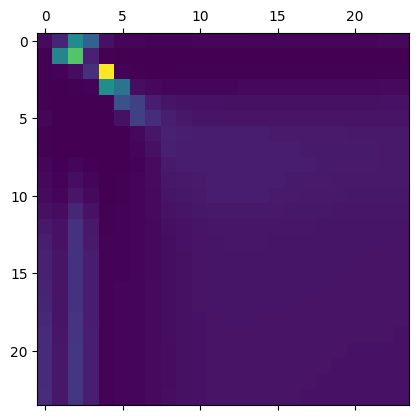

In [103]:
plt.matshow(attention)

In [106]:
sweep_attn_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'hidden_size': {
            'values': [64, 128, 256],
        },
        'encoder_num_layers': {
            'values': [1, 2, 3],
        },
        'bidirectional': {
            'values': [True, False],
        },
        'cell_type': {
            'values': ['LSTM', 'GRU'],
        },
    }
}

In [107]:
def sweep_attn_fn():
    wandb.init()
    config = wandb.config
    dropout_val = 0
    encoder=Encoder(30, config.hidden_size, config.cell_type, num_layers=config.encoder_num_layers, bidirectional=config.bidirectional)
    decoder = AttnDecoder(150, config.hidden_size, 64, config.cell_type, num_layers=1, bidirectional=config.bidirectional)
    model = AttnSeq2seq(encoder, decoder)
    logger = WandbLogger(project='CS6910 Assignment 3', entity='cs20b075')
    trainer = pl.Trainer(max_epochs=5, precision=16, logger=logger)
    trainer.fit(model, train_loader)

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_attn_config, project="CS6910 Assignment 3")
wandb.agent(sweep_id=sweep_id, function=sweep_attn_fn, count=10)

Create sweep with ID: 1t3u8y0a
Sweep URL: https://wandb.ai/cs20b075/CS6910%20Assignment%203/sweeps/1t3u8y0a


wandb: Agent Starting Run: ai7hogtt with config:
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	encoder_num_layers: 2
wandb: 	hidden_size: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/sooraj/.local/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/home/sooraj/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:517: UserWarning: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availa

Sanity Checking: 0it [00:00, ?it/s]

/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  42%|████▏     | 666/1599 [05:34<07:48,  1.99it/s, v_num=ogtt, train_loss_step=0.951, train_acc_step=0.000]

wandb: Ctrl + C detected. Stopping sweep.


Epoch 0:  60%|██████    | 960/1599 [08:19<05:32,  1.92it/s, v_num=ogtt, train_loss_step=1.070, train_acc_step=0.000]

# Testing the models

The best model found for seq2seq without attention was:
- bidirectional LSTM
- 3 decoder layers
- 2 encoder layers
- 200 hidden layer size

While these results are found for 5 epochs, we shall be checking them against 10 epochs for the test set.

In [107]:
encoder  = Encoder(30, 200, cell_type="LSTM", num_layers=2, bidirectional=True, dropout=0.1)
decoder = Decoder(150, 200, cell_type="LSTM", num_layers=3, bidirectional=True)
model = Seq2seq(encoder, decoder)

In [18]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.6 M 
1 | decoder | Decoder | 1.7 M 
------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.236    Total estimated model params size (MB)
2023-05-20 10:25:09.624118: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-20 10:25:09.772983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in oth

Sanity Checking: 0it [00:00, ?it/s]

/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1599/1599 [16:52<00:00,  1.58it/s, v_num=232, train_loss_step=0.367, train_acc_step=0.462, val_loss_step=0.283, val_loss_epoch=0.392, val_acc=0.307, train_loss_epoch=0.268, train_acc_epoch=0.370]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1599/1599 [16:52<00:00,  1.58it/s, v_num=232, train_loss_step=0.367, train_acc_step=0.462, val_loss_step=0.283, val_loss_epoch=0.392, val_acc=0.307, train_loss_epoch=0.268, train_acc_epoch=0.370]


In [19]:
torch.save(model.state_dict(), 'seq2seqmodel.pt')

In [108]:
model.load_state_dict(torch.load('seq2seqmodel.pt'))

<All keys matched successfully>

In [109]:
test_data = get_data(test_path)
output_file = open('predictions_vanilla/test.txt', 'w')
for x in test_data[0]:
    prediction = convert_tensor_to_word(model(convert_word_to_tensor(x, 'eng')), 'hin')
    prediction = prediction[:prediction.find('PAD')]
    output_file.write(x + ',' + prediction + '\n')

In [110]:
output_file.close()

In [96]:
correct_words = 0
for x, y in zip(test_data[0], test_data[1]):
    prediction = model(convert_word_to_tensor(x, 'eng'))
    # print(prediction, convert_word_to_tensor(y, 'hin'))
    correct = (prediction == convert_word_to_tensor(y, 'hin')).sum() == len(prediction)
    if correct.item():
        correct_words += 1
print(correct_words/len(test_data[0]))

0.2783203125


# Testing attention on the test data

The best model with attention was:
- bidirectional LSTM
- 3 encoder layers
- 256 hidden layer size



In [111]:
encoder = Encoder(30, 200, cell_type="LSTM", num_layers=3, bidirectional=True, dropout=0.1)
decoder = AttnDecoder(150, 200, 200, cell_type="LSTM", num_layers=1, bidirectional=True)
model = AttnSeq2seq(encoder, decoder)

In [98]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type        | Params
----------------------------------------
0 | encoder | Encoder     | 1.6 M 
1 | decoder | AttnDecoder | 1.0 M 
----------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.506    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/sooraj/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1599/1599 [16:48<00:00,  1.59it/s, v_num=233, train_loss_step=0.409, train_acc_step=0.308, val_loss_step=0.292, val_loss_epoch=0.341, val_acc=0.361, train_loss_epoch=0.243, train_acc_epoch=0.395]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1599/1599 [16:48<00:00,  1.59it/s, v_num=233, train_loss_step=0.409, train_acc_step=0.308, val_loss_step=0.292, val_loss_epoch=0.341, val_acc=0.361, train_loss_epoch=0.243, train_acc_epoch=0.395]


In [99]:
torch.save(model.state_dict(), 'attnmodel.pt')

In [112]:
model.load_state_dict(torch.load('attnmodel.pt'))

<All keys matched successfully>

In [104]:
test_data = get_data(test_path)
output_file = open('predictions_attention/test.txt', 'w')
for x in test_data[0]:
    prediction, _ = model(convert_word_to_tensor(x, 'eng'))
    prediction = convert_tensor_to_word(prediction, 'hin')
    prediction = prediction[:prediction.find('PAD')]
    output_file.write(x + ',' + prediction + '\n')
output_file.close()

In [105]:
correct_words = 0
for x, y in zip(test_data[0], test_data[1]):
    prediction, _ = model(convert_word_to_tensor(x, 'eng'))
    # print(prediction, convert_word_to_tensor(y, 'hin'))
    correct = (prediction == convert_word_to_tensor(y, 'hin')).sum() == len(prediction)
    if correct.item():
        correct_words += 1
print(correct_words/len(test_data[0]))

0.333251953125


In [149]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [150]:
plt.rcParams['font.family'] = 'Noto Sans'  # or 'Arial Unicode MS'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.sans-serif'] = ['Noto Sans']

कृप्या 6 6 24
धन्यवाद 7 9 24
अच्चा 5 6 24
आदत 3 5 24
वास्तव 6 7 24
सुराज 5 6 24
गूडब्ये 7 7 24
महत्मा 6 7 24
एटेंशशन 7 9 24


/home/sooraj/.local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 108 (l) missing from current font.
  func(*args, **kwargs)
/home/sooraj/.local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 112 (p) missing from current font.
  func(*args, **kwargs)
/home/sooraj/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sooraj/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


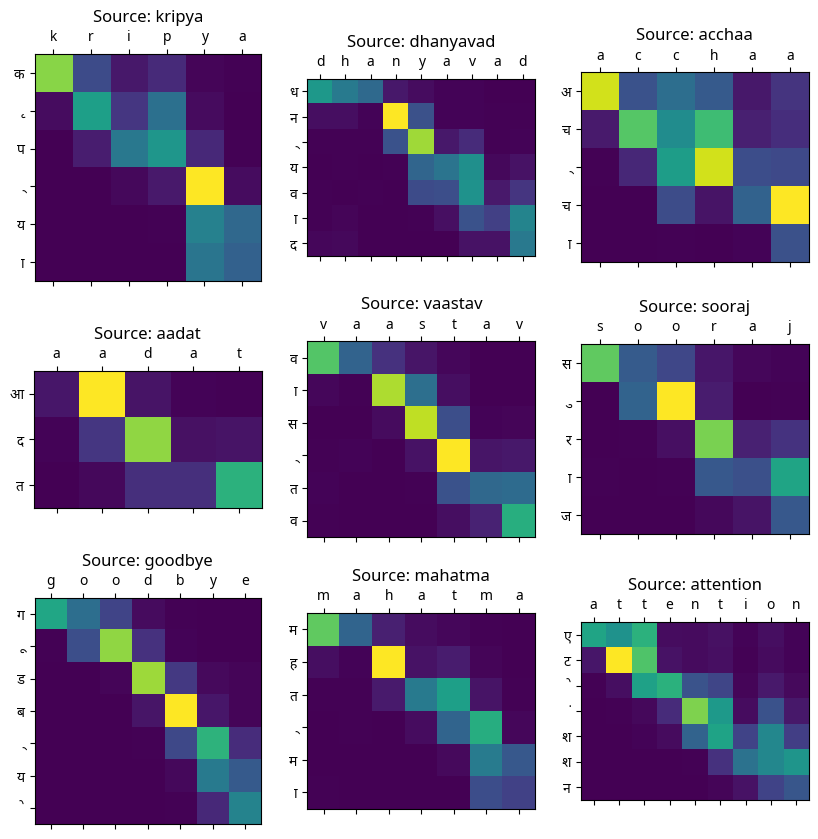

In [164]:
words = ['kripya', 'dhanyavad', 'acchaa', 'aadat', 'vaastav', 'sooraj', 'goodbye', 'mahatma', 'attention']
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
for i, x in enumerate(words):
    prediction, attention = model(convert_word_to_tensor(x, 'eng'))
    attention = [x.detach().numpy() for x in attention]
    prediction_word = convert_tensor_to_word(prediction, 'hin')
    prediction_word = prediction_word[:prediction_word.find('PAD')]
    prediction_word = prediction_word[3:-3]
    prediction_word_length = len(prediction_word)
    print(prediction_word, prediction_word_length, len(x), len(attention))
    axis[i//3, i%3].matshow(np.array(attention).squeeze()[1:prediction_word_length+1, 1:len(x)+1])
    axis[i//3, i%3].set_title("Source: " + x)
    axis[i//3, i%3].set_xticks(range(len(x)), list(x), fontfamily='Noto Sans')
    axis[i//3, i%3].set_yticks(range(prediction_word_length), list(prediction_word), fontfamily='Noto Sans Devanagari')